June 14 update:
I modified the summarizers to output not just N sample N(z) distributions (saved to the file specified via the `output` keyword), but also the single fiducial N(z) estimate, along with a 1 sigma error estimate (saved to the file specified via the `single_NZ` keyword).  I also updated NZDir and included it in this example notebook

In [2]:
import os
import rail
import numpy as np
import pandas as pd
import tables_io
import matplotlib.pyplot as plt
%matplotlib inline

estimator delightPZ not installed


In [3]:
from rail.estimation.algos.knnpz import Inform_KNearNeighPDF, KNearNeighPDF

In [4]:
from rail.estimation.algos.varInference import VarInferenceStack
from rail.estimation.algos.naiveStack import NaiveStack
from rail.estimation.algos.pointEstimateHist import PointEstimateHist
from rail.estimation.algos.NZDir import Inform_NZDir, NZDir
from rail.core.data import TableHandle, QPHandle
from rail.core.stage import RailStage

In [5]:
import qp

In [6]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

To create some N(z) distributions, we'll want some PDFs to work with first, for a quick demo let's just run some photo-z's using the KNearNeighPDF estimator using the 10,000 training galaxies to generate ~20,000 PDFs using data from healpix 9816 of cosmoDC2_v1.1.4 that are included in the RAIL repo:

In [7]:
knn_dict = dict(zmin=0.0, zmax=3.0, nzbins=301, trainfrac=0.75,
                sigma_grid_min=0.01, sigma_grid_max=0.07, ngrid_sigma=10,
                nneigh_min=3, nneigh_max=7, hdf5_groupname='photometry')

In [8]:
pz_train = Inform_KNearNeighPDF.make_stage(name='inform_KNN', model='demo_knn.pkl', **knn_dict)

In [9]:
# Load up the example healpix 9816 data and stick in the DataStore
RAIL_DIR = os.path.dirname(rail.__file__)
trainFile = os.path.join(RAIL_DIR, '../tests/data/test_dc2_training_9816.hdf5')
testFile = os.path.join(RAIL_DIR, '../tests/data/test_dc2_validation_9816.hdf5')
training_data = DS.read_file("training_data", TableHandle, trainFile)
test_data = DS.read_file("test_data", TableHandle, testFile)

In [10]:
# train knnpz
pz_train.inform(training_data)

split into 7669 training and 2556 validation samples
finding best fit sigma and NNeigh...


/Users/sam/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/sam/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)





best fit values are sigma=0.03 and numneigh=6



Inserting handle into data store.  model_inform_KNN: inprogress_demo_knn.pkl, inform_KNN


In [11]:
pz = KNearNeighPDF.make_stage(name='KNN', hdf5_groupname='photometry',
                              model=pz_train.get_handle('model'))
qp_data = pz.estimate(test_data)

/Users/sam/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Inserting handle into data store.  output_KNN: inprogress_output_KNN.fits, KNN


So, `qp_data` now contains the 20,000 PDFs from KNearNeighPDF, we can feed this in to three summarizers to generate an overall N(z) distribution.  We won't bother with any tomographic selections for this demo, just the overall N(z).  It is stored as `qp_data`, but has also been saved to disk as `output_KNN.fits` as an astropy table.  If you want to read in this data to grab the qp Ensemble at a later stage, you can do this via qp with a `ens = qp.read("output_KNN.fits")`

I coded up **quick and dirty** bootstrap versions of the `NaiveStack`, `PointEstimateHist`, and `VarInference` sumarizers.  These are not optimized, are slow, but they do produce N different bootstrap realizations of the overall N(z) which are returned as a qp Ensemble (Note: the current versions of these degraders in `main` branch return only the single overall N(z) rather than samples).  Again, these are temporary, slow versions of the sample generating summarizers that we will improve in the near future, they are mainly meant for demo purposes.

# Naive Stack

Naive stack just "stacks" i.e. sums up, the PDFs and returns a qp.interp distribution with bins defined by np.linspace(zmin, zmax, nzbins), we will create a stack with 41 bins and generate 20 bootstrap realizations

In [12]:
stacker = NaiveStack.make_stage(zmin=0.0, zmax=3.0, nzbins=41, nsamples=20, output="Naive_samples.hdf5", single_NZ="NaiveStack_NZ.hdf5")

In [13]:
naive_results = stacker.summarize(qp_data)

Inserting handle into data store.  output: inprogress_Naive_samples.hdf5, NaiveStack
Inserting handle into data store.  single_NZ: inprogress_NaiveStack_NZ.hdf5, NaiveStack


The results are now in naive_results, but because of the DataStore, the actual *ensemble* is stored in `.data`, let's grab the ensemble and plot a few of the bootstrap sample N(z) estimates:

In [14]:
newens = naive_results.data

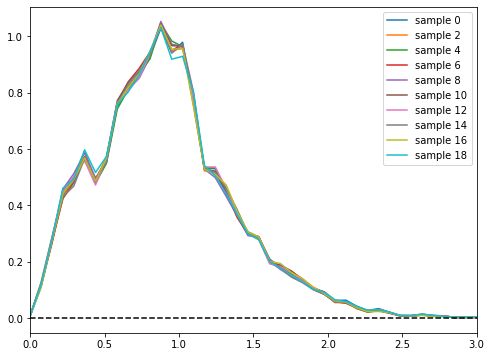

In [15]:
fig, axs = plt.subplots(figsize=(8,6))
for i in range(0, 20, 2):
    newens[i].plot_native(axes=axs, label=f"sample {i}")
axs.plot([0,3],[0,0],'k--')
axs.set_xlim(0,3)
axs.legend(loc='upper right')

The summarizer also outputs a **second** file containing the fiducial N(z), along with an error estimate.  The error estimate is stored in the ancillary data, and consists of the 1 sigma error bounds based on the bootstrap samples.  We saved the fiducial N(z) in the file "NaiveStack_NZ.hdf5",  let's grab these data and plot the error intervals:

In [16]:
naive_nz = qp.read("NaiveStack_NZ.hdf5")
siglow = naive_nz.ancil['sigma_low'].flatten()
sighigh = naive_nz.ancil['sigma_high'].flatten()
errs = (siglow, sighigh)
xvals = naive_nz.metadata()['xvals'].flatten()
yvals = naive_nz.pdf(xvals).flatten()

<ErrorbarContainer object of 3 artists>

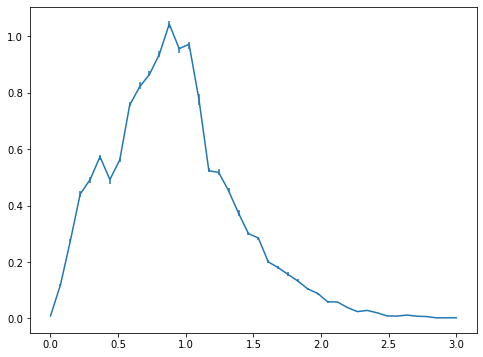

In [17]:
fig, axs = plt.subplots(figsize=(8,6))
plt.errorbar(xvals, yvals, errs)

We see that we have relatively small error bars, reflecting the fact that our bootstrap samples do not show a large variance.

# Point Estimate Hist
PointEstimateHist takes the point estimate mode of each PDF and then histograms these, we'll again generate 41 bootstrap samples of this and plot a few of the resultant histograms.
Note: For some reason the plotting on the histogram distribution in qp is a little wonky, it appears alpha is broken, so this plot is not the best:

In [18]:
pointy = PointEstimateHist.make_stage(zmin=0.0, zmax=3.0, nzbins=41, nsamples=20, single_NZ="point_NZ.hdf5", output="point_samples.hdf5")

In [19]:
%%time
pointy_results = pointy.summarize(qp_data)

Inserting handle into data store.  output: inprogress_point_samples.hdf5, PointEstimateHist
Inserting handle into data store.  single_NZ: inprogress_point_NZ.hdf5, PointEstimateHist
CPU times: user 1.76 s, sys: 24.8 ms, total: 1.78 s
Wall time: 1.51 s


In [20]:
pens = pointy_results.data

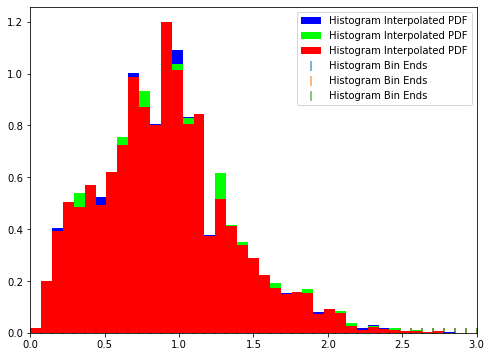

In [21]:
fig, axs = plt.subplots(figsize=(8,6))
pens[0].plot_native(axes=axs, fc = [0, 0, 1, 0.01])
pens[1].plot_native(axes=axs, fc = [0, 1, 0, 0.01])
pens[4].plot_native(axes=axs, fc = [1, 0, 0, 0.01])
axs.set_xlim(0,3)
axs.legend()

Again, we have saved the fiducial N(z) in a separate file, "point_NZ.hdf5", we could read that data in if we desired.

# varInference

VarInference implements Markus' variational inference scheme and returns qp.interp gridded distribution. varInference tends to get a little wonky if you use too many bins, so we'll only use 25 bins. Again let's generate 20 samples and plot a few:

In [22]:
runner=VarInferenceStack.make_stage(name='test_varinf', zmin=0.0,zmax=3.0,nzbins=25, niter=10, nsamples=20,
                                    output="sampletest.hdf5", single_NZ="varinf_NZ.hdf5")

In [23]:
%%time
varinf_results = runner.summarize(qp_data)

Inserting handle into data store.  output_test_varinf: inprogress_sampletest.hdf5, test_varinf
Inserting handle into data store.  single_NZ_test_varinf: inprogress_varinf_NZ.hdf5, test_varinf
CPU times: user 1.21 s, sys: 25.5 ms, total: 1.23 s
Wall time: 1.14 s


In [24]:
vens = varinf_results.data
vens

Let's plot the fiducial N(z) for this distribution and show our error bars.  **As they are small, we'll multiply them by a factor of three so that they show up a bit better on the plot**

In [25]:
varinf_nz = qp.read("varinf_NZ.hdf5")
siglow = varinf_nz.ancil['sigma_low'].flatten()
sighigh = varinf_nz.ancil['sigma_high'].flatten()
errs = (siglow*3., sighigh*3.)
xvals = varinf_nz.metadata()['xvals'].flatten()
yvals = varinf_nz.pdf(xvals).flatten()

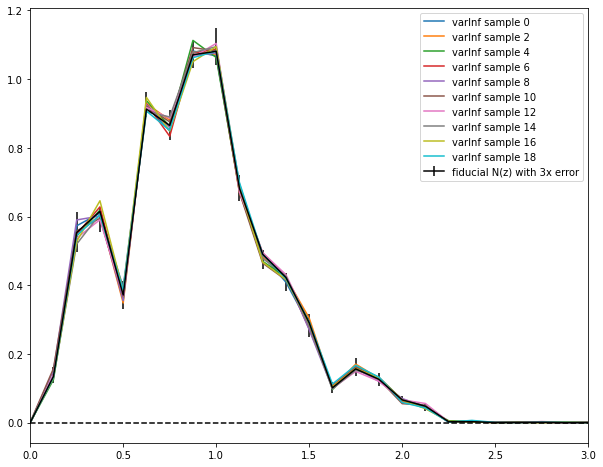

In [26]:
fig, axs = plt.subplots(figsize=(10,8))
for i in range(0,20,2):
    vens[i].plot_native(axes=axs, label=f"varInf sample {i}")
axs.plot([0,3],[0,0],'k--')
axs.errorbar(xvals, yvals, errs, c='k', label="fiducial N(z) with 3x error")
axs.set_xlim(0,3)
axs.legend(loc='upper right')
#axs.set_ylim((0.5, 0.7))

It does appear that, given our factor of three blow-up in the plotted errors, they do accurately reflect the 1 sigma spread in the bootstrap variations at each bin center

# NZDir
NZDir is a different type of summarizer, taking a weighted set of neighbors to a set of training spectroscopic objects to reconstruct the redshift distribution of the photometric sample.  I implemented a bootstrap of the **spectroscopic data** rather than the photometric data, both because it was much easier computationally, and I think that the spectroscopic variance is more important to take account of than simple bootstrap of the large photometric sample.
We must first run the `inform_NZDir` stage to train up the K nearest neigh tree used by NZDir, then we will run `NZDir` to actually construct the N(z) estimate.  

Like PointEstimateHist NZDir returns a qp.hist ensemble of samples

In [27]:
inf_nz = Inform_NZDir.make_stage(n_neigh=8, hdf5_groupname="photometry", model="nzdir_model.pkl")

In [28]:
inf_nz.inform(training_data)

Inserting handle into data store.  model: inprogress_nzdir_model.pkl, Inform_NZDir


In [29]:
nzd = NZDir.make_stage(leafsize=20, zmin=0.0, zmax=3.0, nzbins=31, model="NZDir_model.pkl", hdf5_groupname='photometry',
                       output='NZDir_samples.hdf5', single_NZ='NZDir_NZ.hdf5')

In [30]:
nzd_res = nzd.estimate(test_data)

Inserting handle into data store.  output: inprogress_NZDir_samples.hdf5, NZDir
Inserting handle into data store.  single_NZ: inprogress_NZDir_NZ.hdf5, NZDir


In [31]:
nzd_ens = nzd_res.data

In [32]:
nzdir_nz = qp.read("NZDir_NZ.hdf5")

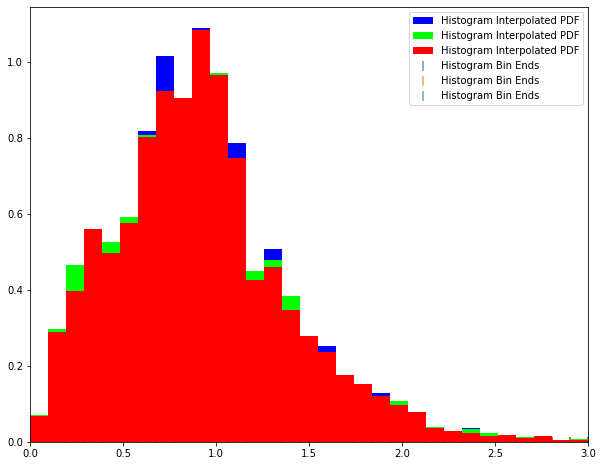

In [33]:
fig, axs = plt.subplots(figsize=(10,8))
nzd_ens[0].plot_native(axes=axs, fc = [0, 0, 1, 0.01])
nzd_ens[1].plot_native(axes=axs, fc = [0, 1, 0, 0.01])
nzd_ens[4].plot_native(axes=axs, fc = [1, 0, 0, 0.01])
axs.set_xlim(0,3)
axs.legend()

As we also wrote out the single estimate of N(z), along with a 1 sigma error estimate, we can read that data from the second file written (specified by the `single_NZ` argument given in NZDir.make_stage above, in this case "NZDir_NZ.hdf5"), and plot up the 1 sigma variation in each of the bin heights:

In [34]:
nzdir_nz = qp.read("NZDir_NZ.hdf5")

In [35]:
nzdbinedges = nzdir_nz.metadata()['bins'].flatten()
nzdbins = 0.5*(nzdbinedges[1:] + nzdbinedges[:-1])
histvals = nzdir_nz.objdata()['pdfs'].flatten()
nzsiglow = nzdir_nz.ancil['sigma_low'].flatten()
nzsighi = nzdir_nz.ancil['sigma_high'].flatten()
errs = (nzsiglow, nzsighi)

In [36]:
nzsiglow.shape

(31,)

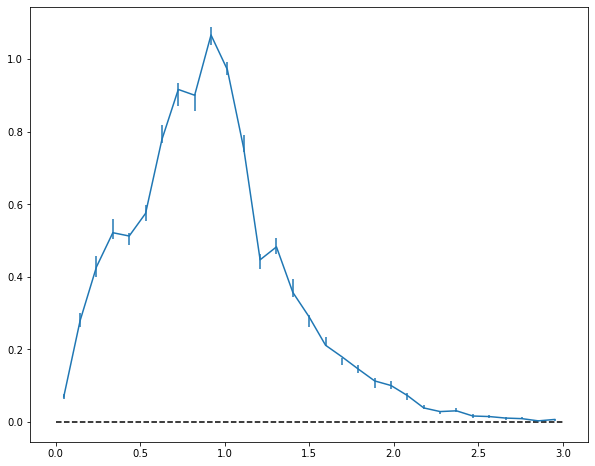

In [37]:
plt.figure(figsize=(10,8))
#plt.scatter(nzdbins, histvals,c='r', s=50)
plt.errorbar(nzdbins, histvals, errs)
plt.plot([0,3],[0,0], 'k--')

# Results

All three results files are qp distributions, NaiveStack and varInference return qp.interp distributions while pointEstimateHist returns a qp.histogram distribution.  Even with the different distributions you can use qp functionality to do things like determine the means, modes, etc... of the distributions.  You could then use the std dev of any of these to estimate a 1 sigma "shift", etc...

In [38]:
zgrid = np.linspace(0,3,41)
names = ['naive', 'point', 'varinf', 'nzdir']
enslist = [newens, pens, vens, nzd_ens]
results_dict = {}
for nm, en in zip(names, enslist):
    results_dict[f'{nm}_modes'] = en.mode(grid=zgrid).flatten()
    results_dict[f'{nm}_means'] = en.mean().flatten()
    results_dict[f'{nm}_std'] = en.std().flatten()

In [39]:
results_dict

{'naive_modes': array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
        0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]),
 'naive_means': array([0.91433419, 0.91069913, 0.91045791, 0.91296805, 0.90675572,
        0.90874547, 0.90939677, 0.90790531, 0.90287537, 0.91391691,
        0.90787679, 0.91275907, 0.91072998, 0.9139442 , 0.91100127,
        0.91430453, 0.91091618, 0.91524105, 0.90678906, 0.90896833]),
 'naive_std': array([0.46131769, 0.45624   , 0.45439423, 0.45558618, 0.45420423,
        0.45215661, 0.45299748, 0.45866392, 0.4541742 , 0.45612015,
        0.45162384, 0.4560757 , 0.45755581, 0.4561557 , 0.45370651,
        0.45859552, 0.45334623, 0.45583576, 0.45921264, 0.45691466]),
 'point_modes': array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
        0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]),
 'point_means': array([0.90699826, 0.9100612 , 0.9010477 , 0.90306223, 0.90506245,
        0.91085198, 0.90354886, 0.91034388, 0.90919885, 0.9086657 ,
       

You can also use qp to compute quantities the pdf, cdf, ppf, etc... on any grid that you want, much of the functionality of scipy.stats distributions have been inherited by qp ensembles

In [40]:
newgrid = np.linspace(0.005,2.995, 35)
naive_pdf = newens.pdf(newgrid)
point_cdf = pens.cdf(newgrid)
var_ppf = vens.ppf(newgrid)

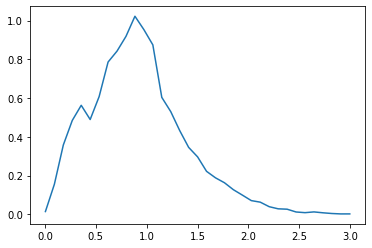

In [41]:
plt.plot(newgrid, naive_pdf[0])

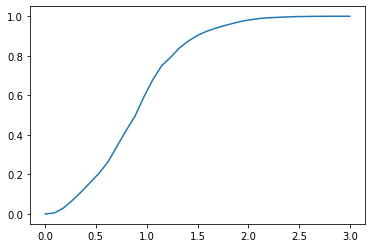

In [42]:
plt.plot(newgrid, point_cdf[0])

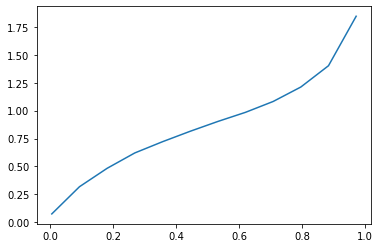

In [43]:
plt.plot(newgrid, var_ppf[0])

# Shifts

If you want to "shift" a PDF, you can just evaluate the PDF on a shifted grid, for example to shift the PDF by +0.0375 in redshift you could evaluate on a shifted grid.  For now we can just do this "by hand", we could easily implement `shift` functionality in qp, I think.

In [44]:
def_grid = np.linspace(0., 3., 41)
shift_grid = def_grid - 0.0675
native_nz = newens.pdf(def_grid)
shift_nz = newens.pdf(shift_grid)

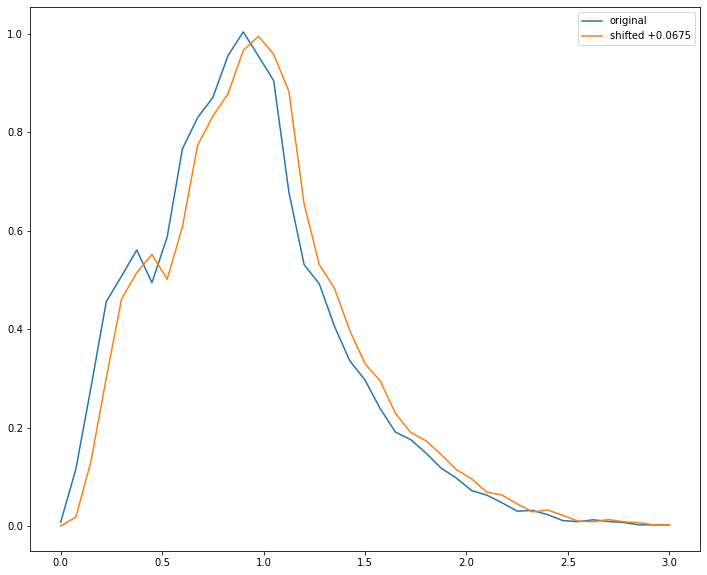

In [45]:
fig=plt.figure(figsize=(12,10))
plt.plot(def_grid, native_nz[0], label="original")
plt.plot(def_grid, shift_nz[0], label="shifted +0.0675")
plt.legend(loc='upper right')

You can estimate how much shift you might expect based on the statistics of our bootstrap samples, say the std dev of the means for the NZDir-derived distribution:

In [46]:
results_dict['nzdir_means']

array([0.9158019 , 0.9147637 , 0.92114241, 0.91399009, 0.92005304,
       0.92537537, 0.92033582, 0.92329289, 0.92013787, 0.91180258,
       0.92324442, 0.9272774 , 0.92032303, 0.91326631, 0.92243109,
       0.92310235, 0.91475898, 0.92163795, 0.91294111, 0.91959992])

In [47]:
spread = np.std(results_dict['nzdir_means'])

In [48]:
spread

0.004377831637330154

Again, not a huge spread in predicted mean redshifts based solely on bootstraps, even with only ~20,000 galaxies.